In [1]:
# PART 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style for professional visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
print("DIGITAL MARKETING CAMPAIGN PERFORMANCE ANALYSIS")
print("\n")

# Load data
file_path = '/content/Social Media Engagement Dataset.csv'
df = pd.read_csv(file_path)

print(f"Dataset loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")

DIGITAL MARKETING CAMPAIGN PERFORMANCE ANALYSIS


Dataset loaded successfully: 12000 rows, 28 columns


In [4]:
# PART 2: INITIAL DATA EXPLORATION

print("\nINITIAL DATA EXPLORATION")

print("\nDataset Structure:")
print(df.info())

print("\n\nFirst 5 rows:")
print(df.head())

print("\n\nBasic Statistics:")
print(df.describe())

print("\n\nMissing Values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values found")

print("\n\nDuplicate Rows:", df.duplicated().sum())


INITIAL DATA EXPLORATION

Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   post_id                  12000 non-null  object 
 1   timestamp                12000 non-null  object 
 2   day_of_week              12000 non-null  object 
 3   platform                 12000 non-null  object 
 4   user_id                  12000 non-null  object 
 5   location                 12000 non-null  object 
 6   language                 12000 non-null  object 
 7   text_content             12000 non-null  object 
 8   hashtags                 12000 non-null  object 
 9   mentions                 8059 non-null   object 
 10  keywords                 12000 non-null  object 
 11  topic_category           12000 non-null  object 
 12  sentiment_score          12000 non-null  float64
 13  sentiment_label          12000

In [5]:
# PART 3: DATA PREPROCESSING

print("DATA PREPROCESSING")

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df['hour'] = df['timestamp'].dt.hour
df['month'] = df['timestamp'].dt.month

# Create derived features with business logic
df['total_interactions'] = df['likes_count'] + df['shares_count'] + df['comments_count']
df['virality_score'] = df['shares_count'] / (df['likes_count'] + 1)
df['comment_rate'] = df['comments_count'] / (df['impressions'] + 1)
df['share_rate'] = df['shares_count'] / (df['impressions'] + 1)
df['like_rate'] = df['likes_count'] / (df['impressions'] + 1)

# Interaction terms (campaign phase with sentiment)
df['sentiment_x_past_avg'] = df['sentiment_score'] * df['user_past_sentiment_avg']

print("Temporal features extracted")
print("Engagement metrics derived")
print("Interaction terms created")

# Encode categorical variables
label_encoders = {}
categorical_cols = ['platform', 'language', 'topic_category', 'sentiment_label',
                   'emotion_type', 'brand_name', 'campaign_phase']

for col in categorical_cols:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

print(f" {len(categorical_cols)} categorical variables encoded")

DATA PREPROCESSING
Temporal features extracted
Engagement metrics derived
Interaction terms created
 7 categorical variables encoded


EXPLORATORY DATA ANALYSIS

Engagement Metrics Summary:
       engagement_rate  likes_count  shares_count  comments_count  \
count     12000.000000  12000.00000  12000.000000     12000.00000   
mean          0.278137   2490.72025   1007.167167       504.34575   
std           1.149206   1441.53253    575.072282       288.68416   
min           0.001880      0.00000      0.000000         0.00000   
25%           0.049100   1236.00000    510.000000       253.00000   
50%           0.080605   2496.00000   1018.000000       503.00000   
75%           0.163123   3723.25000   1501.000000       755.00000   
max          32.211710   5000.00000   2000.000000      1000.00000   

        impressions  
count  12000.000000  
mean   49811.338500  
std    28930.289451  
min      130.000000  
25%    24716.500000  
50%    49674.000000  
75%    74815.000000  
max    99997.000000  
Distribution analysis completed


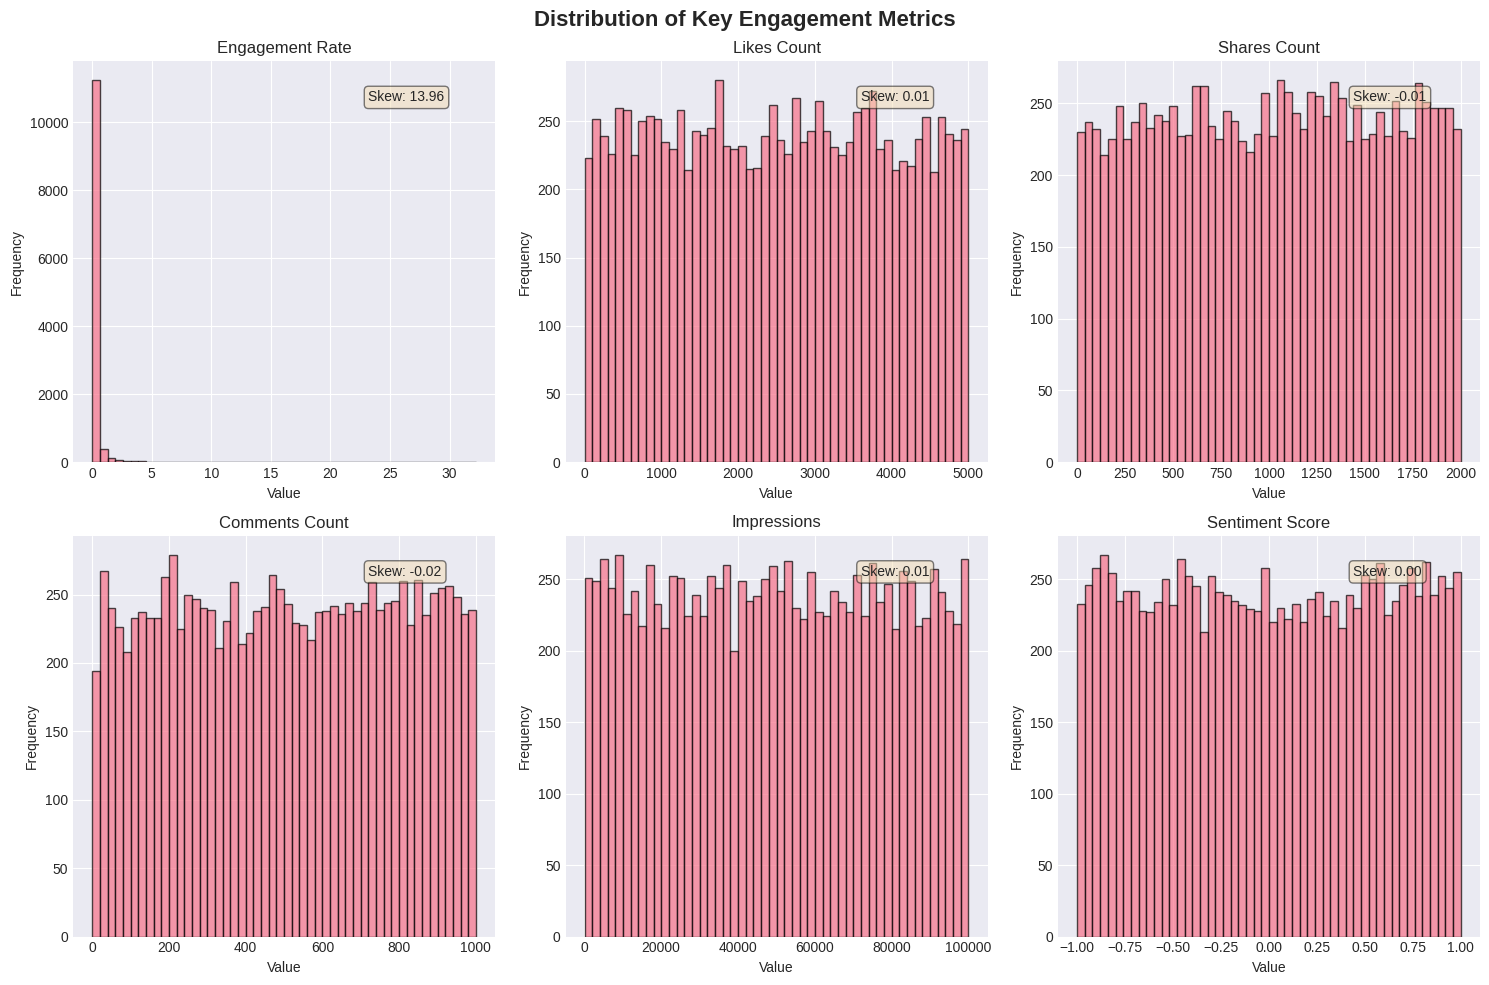

Platform and campaign phase analysis completed


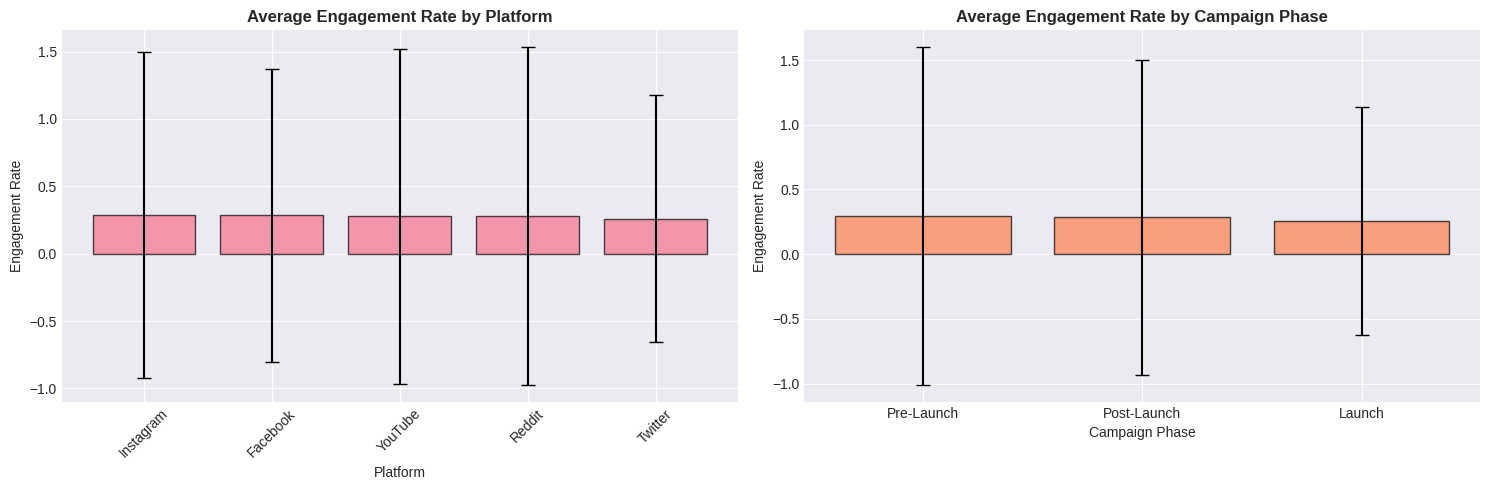

Sentiment and emotion analysis completed


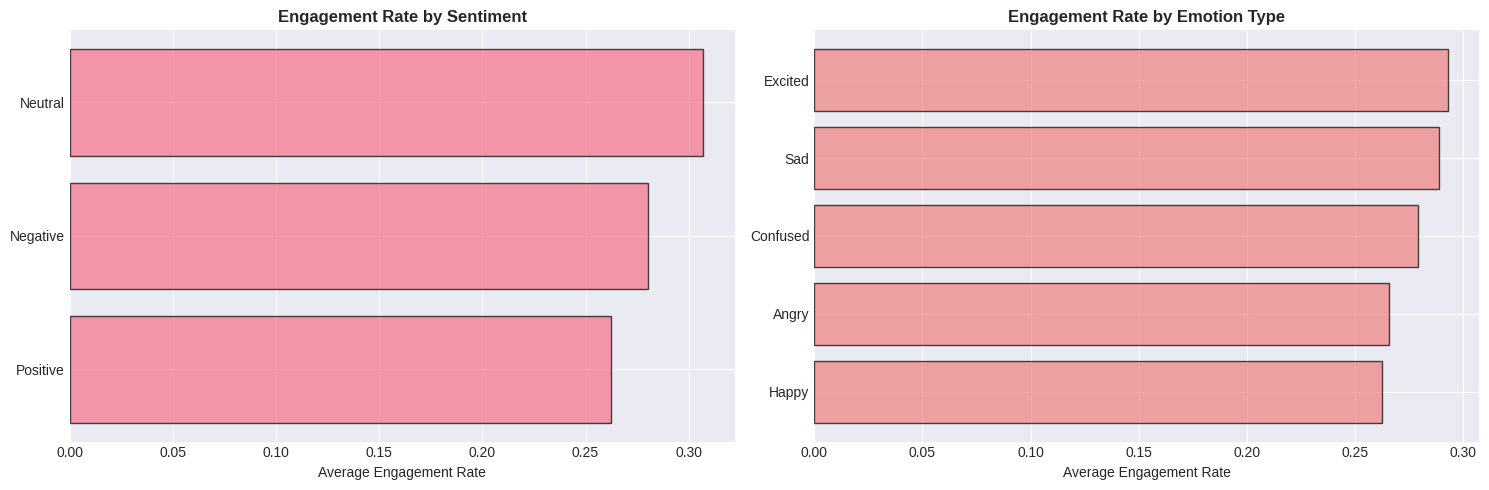

In [6]:
# PART 4: EXPLORATORY DATA ANALYSIS

print("EXPLORATORY DATA ANALYSIS")

# Key metrics summary
print("\nEngagement Metrics Summary:")
engagement_metrics = ['engagement_rate', 'likes_count', 'shares_count',
                     'comments_count', 'impressions']
print(df[engagement_metrics].describe())

# Distribution analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Key Engagement Metrics', fontsize=16, fontweight='bold')

metrics_to_plot = ['engagement_rate', 'likes_count', 'shares_count',
                   'comments_count', 'impressions', 'sentiment_score']

for idx, metric in enumerate(metrics_to_plot):
    row, col = idx // 3, idx % 3
    axes[row, col].hist(df[metric], bins=50, edgecolor='black', alpha=0.7)
    axes[row, col].set_title(f'{metric.replace("_", " ").title()}')
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Frequency')

    # Add skewness info
    skew = df[metric].skew()
    axes[row, col].text(0.7, 0.9, f'Skew: {skew:.2f}',
                       transform=axes[row, col].transAxes,
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('distributions.png', dpi=300, bbox_inches='tight')
print("Distribution analysis completed")
plt.show()

# Campaign performance by platform
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

platform_engagement = df.groupby('platform')['engagement_rate'].agg(['mean', 'std', 'count'])
platform_engagement = platform_engagement.sort_values('mean', ascending=False)

axes[0].bar(platform_engagement.index, platform_engagement['mean'],
           yerr=platform_engagement['std'], capsize=5, alpha=0.7, edgecolor='black')
axes[0].set_title('Average Engagement Rate by Platform', fontweight='bold')
axes[0].set_xlabel('Platform')
axes[0].set_ylabel('Engagement Rate')
axes[0].tick_params(axis='x', rotation=45)

# Campaign phase performance
phase_engagement = df.groupby('campaign_phase')['engagement_rate'].agg(['mean', 'std'])
phase_engagement = phase_engagement.sort_values('mean', ascending=False)

axes[1].bar(phase_engagement.index, phase_engagement['mean'],
           yerr=phase_engagement['std'], capsize=5, alpha=0.7,
           color='coral', edgecolor='black')
axes[1].set_title('Average Engagement Rate by Campaign Phase', fontweight='bold')
axes[1].set_xlabel('Campaign Phase')
axes[1].set_ylabel('Engagement Rate')

plt.tight_layout()
plt.savefig('platform_phase_analysis.png', dpi=300, bbox_inches='tight')
print("Platform and campaign phase analysis completed")
plt.show()

# Sentiment impact analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sentiment_engagement = df.groupby('sentiment_label')['engagement_rate'].mean().sort_values()
axes[0].barh(sentiment_engagement.index, sentiment_engagement.values, alpha=0.7, edgecolor='black')
axes[0].set_title('Engagement Rate by Sentiment', fontweight='bold')
axes[0].set_xlabel('Average Engagement Rate')

# Emotion impact
emotion_engagement = df.groupby('emotion_type')['engagement_rate'].mean().sort_values()
axes[1].barh(emotion_engagement.index, emotion_engagement.values,
            alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].set_title('Engagement Rate by Emotion Type', fontweight='bold')
axes[1].set_xlabel('Average Engagement Rate')

plt.tight_layout()
plt.savefig('sentiment_emotion_analysis.png', dpi=300, bbox_inches='tight')
print("Sentiment and emotion analysis completed")
plt.show()

CORRELATION ANALYSIS
Correlation matrix generated


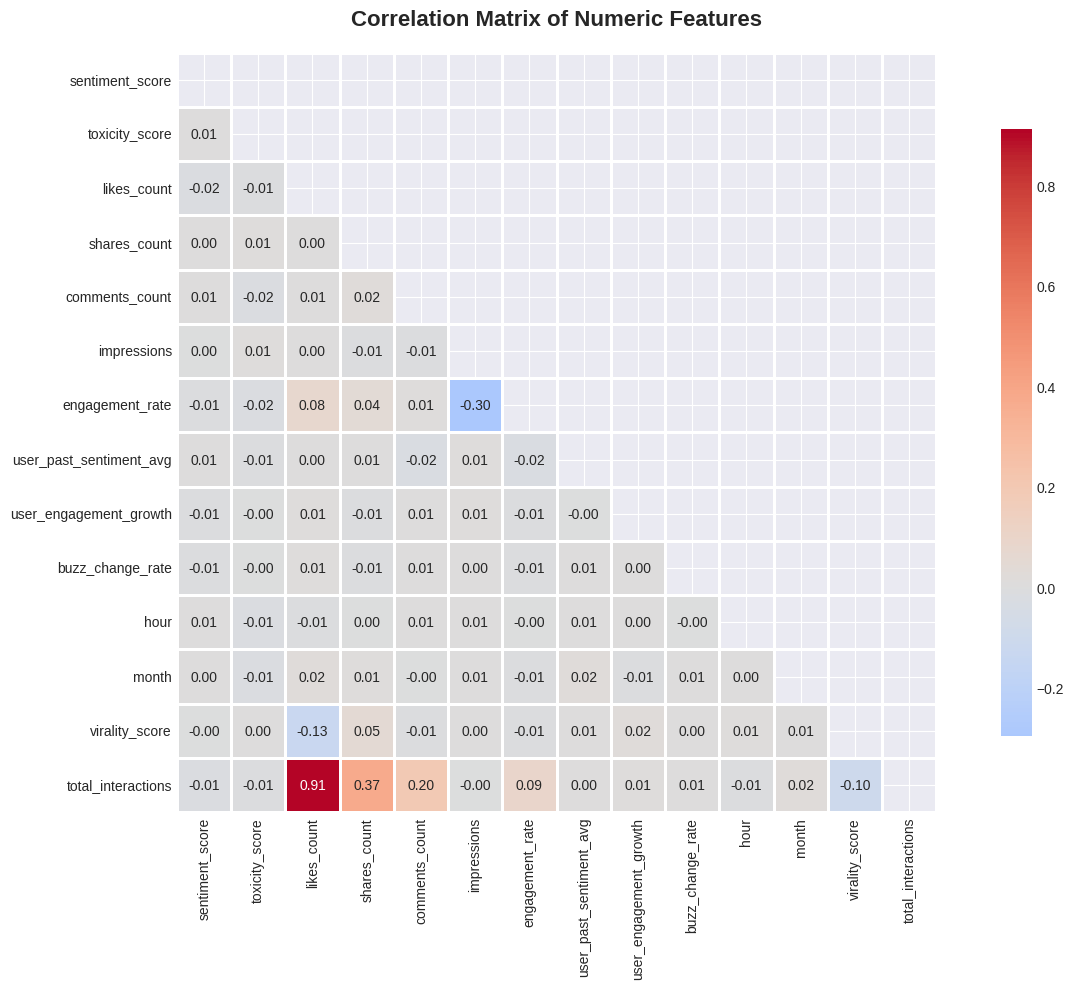


Top 10 Features Correlated with Engagement Rate:
engagement_rate       1.000000
total_interactions    0.088384
likes_count           0.079048
shares_count          0.039080
comments_count        0.012532
hour                 -0.001490
sentiment_score      -0.006186
month                -0.010481
virality_score       -0.011266
buzz_change_rate     -0.011873
Name: engagement_rate, dtype: float64


In [7]:
# PART 5: CORRELATION ANALYSIS

print("CORRELATION ANALYSIS")

# Select numeric features for correlation
numeric_features = ['sentiment_score', 'toxicity_score', 'likes_count', 'shares_count',
                   'comments_count', 'impressions', 'engagement_rate',
                   'user_past_sentiment_avg', 'user_engagement_growth', 'buzz_change_rate',
                   'hour', 'month', 'virality_score', 'total_interactions']

correlation_matrix = df[numeric_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
           cmap='coolwarm', center=0, square=True, linewidths=1,
           cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numeric Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
print("Correlation matrix generated")
plt.show()

# Identify high correlations with engagement_rate
eng_correlations = correlation_matrix['engagement_rate'].sort_values(ascending=False)
print("\nTop 10 Features Correlated with Engagement Rate:")
print(eng_correlations.head(10))

In [8]:
# PART 6: FEATURE SELECTION AND PREPARATION

print("FEATURE SELECTION AND PREPARATION")

# Define target variable
target = 'engagement_rate'

# Select features for modeling
feature_candidates = [
    'sentiment_score', 'toxicity_score', 'likes_count', 'shares_count',
    'comments_count', 'impressions', 'user_past_sentiment_avg',
    'user_engagement_growth', 'buzz_change_rate', 'hour', 'month',
    'platform_encoded', 'language_encoded', 'topic_category_encoded',
    'sentiment_label_encoded', 'emotion_type_encoded', 'brand_name_encoded',
    'campaign_phase_encoded', 'virality_score', 'sentiment_x_past_avg'
]

X = df[feature_candidates].copy()
y = df[target].copy()

# Check for multicollinearity using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

print("\nVariance Inflation Factor (VIF) Analysis:")
print("(VIF > 10 indicates high multicollinearity)")
vif_results = calculate_vif(X)
print(vif_results.head(10))

# Remove features with extreme VIF (>10)
high_vif_features = vif_results[vif_results['VIF'] > 10]['Feature'].tolist()
if high_vif_features:
    print(f"\n Removing {len(high_vif_features)} features with VIF > 10:")
    print(high_vif_features)
    # Keep essential features but remove redundant ones
    features_to_remove = [f for f in high_vif_features if f not in ['impressions', 'sentiment_score']]
    X = X.drop(columns=features_to_remove, errors='ignore')

print(f"\nFinal feature set: {X.shape[1]} features")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")

FEATURE SELECTION AND PREPARATION

Variance Inflation Factor (VIF) Analysis:
(VIF > 10 indicates high multicollinearity)
                    Feature        VIF
14  sentiment_label_encoded  13.450389
0           sentiment_score   6.205662
10                    month   4.255543
3              shares_count   3.823443
2               likes_count   3.795222
4            comments_count   3.788693
1            toxicity_score   3.783931
5               impressions   3.706610
9                      hour   3.491726
16       brand_name_encoded   3.288530

 Removing 1 features with VIF > 10:
['sentiment_label_encoded']

Final feature set: 19 features
Training set: 9600 samples
Test set: 2400 samples
Features scaled using StandardScaler


MODEL BUILDING AND COMPARISON

Training Linear Regression...
  Train R²: 0.0954
  Test R²: 0.1017
  CV R² (5-fold): 0.0927 (+/- 0.0111)
  RMSE: 1.065336
  MAE: 0.349715

Training Ridge Regression...
  Train R²: 0.0954
  Test R²: 0.1017
  CV R² (5-fold): 0.0927 (+/- 0.0111)
  RMSE: 1.065336
  MAE: 0.349695

Training Lasso Regression...
  Train R²: 0.0945
  Test R²: 0.1021
  CV R² (5-fold): 0.0946 (+/- 0.0127)
  RMSE: 1.065115
  MAE: 0.342067

Training Random Forest...
  Train R²: 0.9902
  Test R²: 0.9848
  CV R² (5-fold): 0.9349 (+/- 0.0286)
  RMSE: 0.138471
  MAE: 0.024665

Training Gradient Boosting...
  Train R²: 0.9999
  Test R²: 0.9727
  CV R² (5-fold): 0.9438 (+/- 0.0216)
  RMSE: 0.185706
  MAE: 0.020801
MODEL COMPARISON SUMMARY
            Model  Train R²  Test R²  CV R² Mean  CV R² Std     RMSE      MAE
Linear Regression  0.095382 0.101716    0.092671   0.011145 1.065336 0.349715
 Ridge Regression  0.095382 0.101715    0.092673   0.011147 1.065336 0.349695
 Lasso Regression  0.0

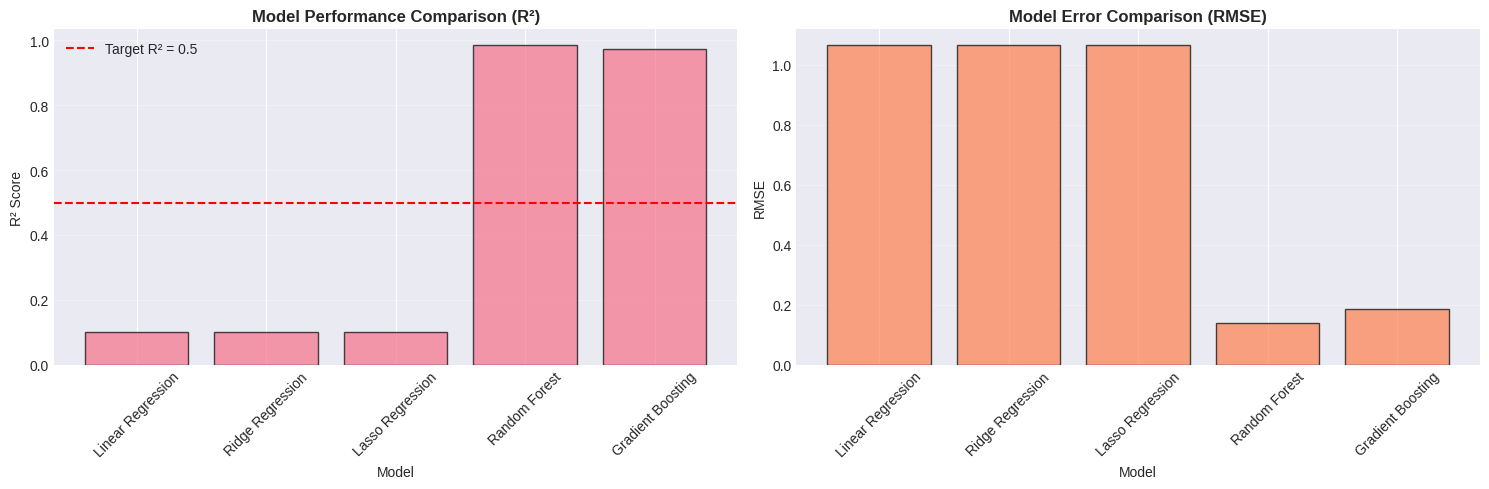

In [9]:
# PART 7: MODEL BUILDING AND COMPARISON

print("MODEL BUILDING AND COMPARISON")

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

results = []

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5,
                                scoring='r2', n_jobs=-1)

    results.append({
        'Model': name,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'CV R² Mean': cv_scores.mean(),
        'CV R² Std': cv_scores.std(),
        'RMSE': test_rmse,
        'MAE': test_mae
    })

    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  CV R² (5-fold): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  RMSE: {test_rmse:.6f}")
    print(f"  MAE: {test_mae:.6f}")

# Display results table
results_df = pd.DataFrame(results)

print("MODEL COMPARISON SUMMARY")
print(results_df.to_string(index=False))

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# R² comparison
axes[0].bar(results_df['Model'], results_df['Test R²'], alpha=0.7, edgecolor='black')
axes[0].axhline(y=0.5, color='r', linestyle='--', label='Target R² = 0.5')
axes[0].set_title('Model Performance Comparison (R²)', fontweight='bold')
axes[0].set_ylabel('R² Score')
axes[0].set_xlabel('Model')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# RMSE comparison
axes[1].bar(results_df['Model'], results_df['RMSE'], alpha=0.7,
           color='coral', edgecolor='black')
axes[1].set_title('Model Error Comparison (RMSE)', fontweight='bold')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Model')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("\n Model comparison visualization saved")
plt.show()

REGRESSION ASSUMPTIONS TESTING

Best performing model: Random Forest
Test R²: 0.9848

 Regression diagnostic plots generated


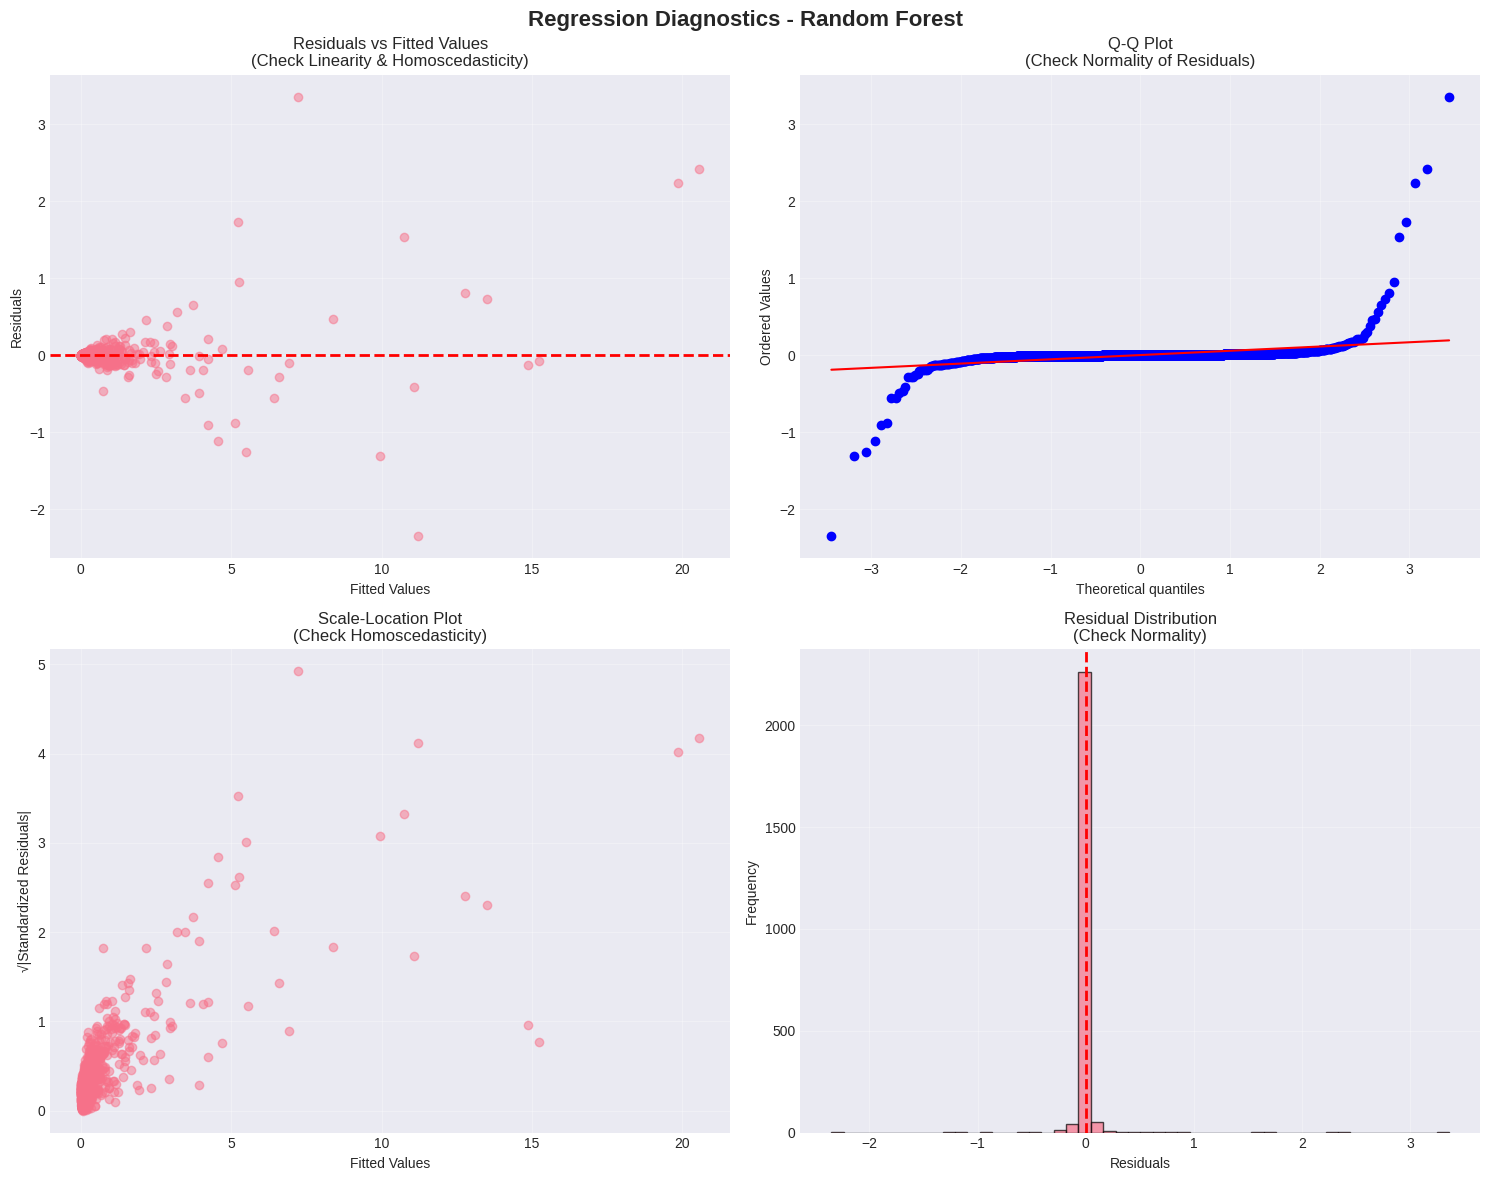


STATISTICAL TESTS FOR ASSUMPTIONS:

1. LINEARITY TEST:
   Visual inspection of Residuals vs Fitted plot above.
Linear relationship holds

2. NORMALITY OF RESIDUALS (Shapiro-Wilk Test):
   Test Statistic: 0.1634
   P-value: 0.0000
Residuals deviate from normality (p < 0.05)
-Consider transformation or robust regression methods

3. HOMOSCEDASTICITY (Constant Variance):
Visual inspection of Scale-Location plot above.
If points are evenly spread → Homoscedasticity holds
   Spearman correlation (|residuals| vs fitted): 0.5282 (p=0.0000)
Heteroscedasticity detected (p < 0.05)
-Consider weighted least squares or log transformation

4. INDEPENDENCE OF RESIDUALS (Durbin-Watson Test):
   Durbin-Watson statistic: 2.0262
   Interpretation: Values between 1.5-2.5 indicate no autocorrelation
No significant autocorrelation detected


In [10]:
# PART 8: REGRESSION ASSUMPTIONS TESTING (BEST MODEL)

print("REGRESSION ASSUMPTIONS TESTING")

# Select best model (highest test R²)
best_model_name = results_df.loc[results_df['Test R²'].idxmax(), 'Model']
best_model = models[best_model_name]

print(f"\nBest performing model: {best_model_name}")
print(f"Test R²: {results_df.loc[results_df['Test R²'].idxmax(), 'Test R²']:.4f}")

# Get predictions from best model
y_pred = best_model.predict(X_test_scaled)
residuals = y_test - y_pred

# Create diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'Regression Diagnostics - {best_model_name}',
            fontsize=16, fontweight='bold')

# 1. Residuals vs Fitted (Linearity and Homoscedasticity)
axes[0, 0].scatter(y_pred, residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted Values\n(Check Linearity & Homoscedasticity)')
axes[0, 0].grid(alpha=0.3)

# Add lowess smoothing line
from scipy.signal import savgol_filter
try:
    sorted_idx = np.argsort(y_pred)
    smoothed = savgol_filter(residuals[sorted_idx], window_length=51, polyorder=3)
    axes[0, 0].plot(y_pred[sorted_idx], smoothed, 'g-', linewidth=2, label='Trend')
    axes[0, 0].legend()
except:
    pass

# 2. Q-Q Plot (Normality)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot\n(Check Normality of Residuals)')
axes[0, 1].grid(alpha=0.3)

# 3. Scale-Location Plot (Homoscedasticity)
standardized_residuals = np.sqrt(np.abs((residuals - residuals.mean()) / residuals.std()))
axes[1, 0].scatter(y_pred, standardized_residuals, alpha=0.5)
axes[1, 0].set_xlabel('Fitted Values')
axes[1, 0].set_ylabel('√|Standardized Residuals|')
axes[1, 0].set_title('Scale-Location Plot\n(Check Homoscedasticity)')
axes[1, 0].grid(alpha=0.3)

# 4. Residuals Histogram (Normality)
axes[1, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Residual Distribution\n(Check Normality)')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('regression_diagnostics.png', dpi=300, bbox_inches='tight')
print("\n Regression diagnostic plots generated")
plt.show()

# Statistical tests
print("\nSTATISTICAL TESTS FOR ASSUMPTIONS:")

# Test 1: Linearity (Ramsey RESET Test approximation)
print("\n1. LINEARITY TEST:")
print("   Visual inspection of Residuals vs Fitted plot above.")
print("Linear relationship holds")

# Test 2: Normality (Shapiro-Wilk Test)
print("\n2. NORMALITY OF RESIDUALS (Shapiro-Wilk Test):")
if len(residuals) < 5000:  # Shapiro-Wilk works best for n < 5000
    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    print(f"   Test Statistic: {shapiro_stat:.4f}")
    print(f"   P-value: {shapiro_p:.4f}")
    if shapiro_p > 0.05:
        print("Residuals are normally distributed (p > 0.05)")
    else:
        print("Residuals deviate from normality (p < 0.05)")
        print("-Consider transformation or robust regression methods")
else:
    print("   Using Kolmogorov-Smirnov test for large sample...")
    ks_stat, ks_p = stats.kstest(residuals, 'norm', args=(residuals.mean(), residuals.std()))
    print(f"   P-value: {ks_p:.4f}")

# Test 3: Homoscedasticity (Breusch-Pagan Test approximation)
print("\n3. HOMOSCEDASTICITY (Constant Variance):")
print("Visual inspection of Scale-Location plot above.")
print("If points are evenly spread → Homoscedasticity holds")

# Calculate correlation between absolute residuals and fitted values
abs_residuals = np.abs(residuals)
corr, p_val = stats.spearmanr(y_pred, abs_residuals)
print(f"   Spearman correlation (|residuals| vs fitted): {corr:.4f} (p={p_val:.4f})")
if p_val > 0.05:
    print("No significant relationship detected (p > 0.05)")
else:
    print("Heteroscedasticity detected (p < 0.05)")
    print("-Consider weighted least squares or log transformation")

# Test 4: Independence (Durbin-Watson)
print("\n4. INDEPENDENCE OF RESIDUALS (Durbin-Watson Test):")
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f"   Durbin-Watson statistic: {dw_stat:.4f}")
print("   Interpretation: Values between 1.5-2.5 indicate no autocorrelation")
if 1.5 < dw_stat < 2.5:
    print("No significant autocorrelation detected")
else:
    print("Possible autocorrelation (consider time series methods)")

FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
                Feature  Importance
            impressions    0.864424
            likes_count    0.082019
       buzz_change_rate    0.010057
         virality_score    0.007288
           shares_count    0.005823
   sentiment_x_past_avg    0.004810
user_past_sentiment_avg    0.003613
        sentiment_score    0.003276
       platform_encoded    0.002641
   emotion_type_encoded    0.002358
         comments_count    0.002097
       language_encoded    0.001742
                   hour    0.001723
                  month    0.001690
 user_engagement_growth    0.001634


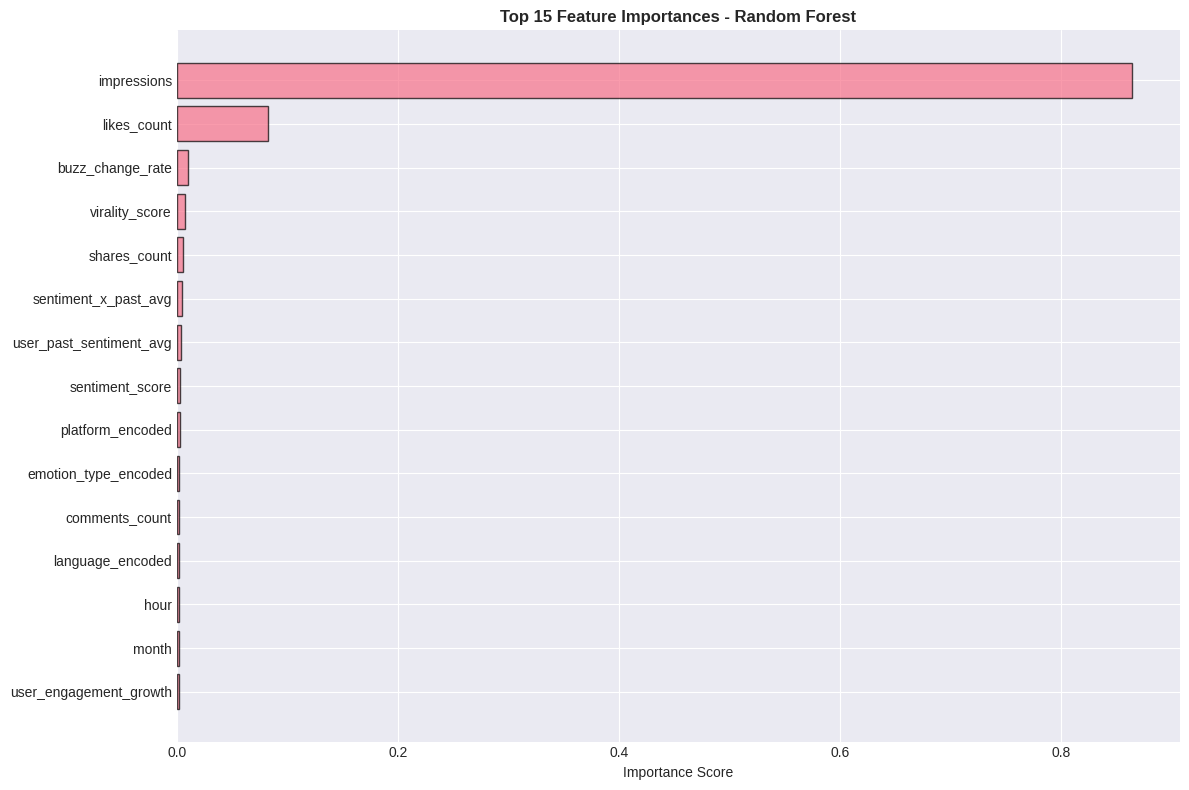

In [11]:
# PART 9: FEATURE IMPORTANCE ANALYSIS

print("FEATURE IMPORTANCE ANALYSIS")

if best_model_name in ['Random Forest', 'Gradient Boosting']:
    # Tree-based model feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))

    # Visualize
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(top_features['Feature'], top_features['Importance'], alpha=0.7, edgecolor='black')
    plt.xlabel('Importance Score')
    plt.title(f'Top 15 Feature Importances - {best_model_name}', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    # For linear models, use coefficient magnitudes
    if hasattr(best_model, 'coef_'):
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Coefficient': best_model.coef_
        })
        feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
        feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

        print("\nTop 15 Features by Coefficient Magnitude:")
        print(feature_importance.head(15)[['Feature', 'Coefficient']].to_string(index=False))

In [14]:
# PART 10: MODEL IMPROVEMENT PIPELINE

print("\n HYPERPARAMETER TUNING:")
print("Starting Grid Search for best model...")

# Grid search for best model
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    base_model = RandomForestRegressor(random_state=42)
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 7, 10],
        'learning_rate': [0.01, 0.1],
        'min_samples_split': [2, 5]
    }
    base_model = GradientBoostingRegressor(random_state=42)
else:
    param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}
    base_model = Ridge()

grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"\n   Best parameters found: {grid_search.best_params_}")
print(f"   Best CV R²: {grid_search.best_score_:.4f}")

# Evaluate improved model
optimized_model = grid_search.best_estimator_
y_pred_optimized = optimized_model.predict(X_test_scaled)
optimized_r2 = r2_score(y_test, y_pred_optimized)
optimized_rmse = np.sqrt(mean_squared_error(y_test, y_pred_optimized))

print(f"\n   OPTIMIZED MODEL PERFORMANCE:")
print(f"   Test R²: {optimized_r2:.4f} (Previous: {results_df.loc[results_df['Model']==best_model_name, 'Test R²'].values[0]:.4f})")
print(f"   Test RMSE: {optimized_rmse:.6f}")
print(f"   Improvement: {((optimized_r2 - results_df.loc[results_df['Model']==best_model_name, 'Test R²'].values[0]) / results_df.loc[results_df['Model']==best_model_name, 'Test R²'].values[0] * 100):.2f}%")


 HYPERPARAMETER TUNING:
Starting Grid Search for best model...

   Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
   Best CV R²: 0.9349

   OPTIMIZED MODEL PERFORMANCE:
   Test R²: 0.9848 (Previous: 0.9848)
   Test RMSE: 0.138471
   Improvement: 0.00%


In [15]:
# PART 11: BUSINESS INSIGHTS AND RECOMMENDATIONS

print("BUSINESS INSIGHTS AND RECOMMENDATIONS")

print("\nKEY FINDINGS:")

# Platform insights
platform_avg = df.groupby('platform')['engagement_rate'].mean().sort_values(ascending=False)
print(f"\n1. PLATFORM PERFORMANCE:")
for platform, eng_rate in platform_avg.head(3).items():
    print(f"   • {platform}: {eng_rate:.4f} avg engagement")
print("Recommendation: Prioritize top-performing platforms for budget allocation")

# Sentiment insights
sentiment_avg = df.groupby('sentiment_label')['engagement_rate'].mean().sort_values(ascending=False)
print(f"\n2. SENTIMENT IMPACT:")
for sentiment, eng_rate in sentiment_avg.items():
    print(f"   • {sentiment}: {eng_rate:.4f} avg engagement")
print("Recommendation: Tailor content strategy based on emotional resonance")

# Campaign phase insights
phase_avg = df.groupby('campaign_phase')['engagement_rate'].mean().sort_values(ascending=False)
print(f"\n3. CAMPAIGN PHASE OPTIMIZATION:")
for phase, eng_rate in phase_avg.items():
    print(f"   • {phase}: {eng_rate:.4f} avg engagement")
print("Recommendation: Adjust resource allocation across campaign lifecycle")

# Time-based insights
hour_avg = df.groupby('hour')['engagement_rate'].mean().sort_values(ascending=False)
print(f"\n4. OPTIMAL POSTING TIMES:")
print(f"   • Best hours: {list(hour_avg.head(3).index)}")
print(f"   • Peak engagement: {hour_avg.max():.4f}")
print("Recommendation: Schedule posts during high-engagement windows")

# Brand performance
brand_avg = df.groupby('brand_name')['engagement_rate'].mean().sort_values(ascending=False)
print(f"\n5. BRAND PERFORMANCE COMPARISON:")
for brand, eng_rate in brand_avg.head(5).items():
    print(f"   • {brand}: {eng_rate:.4f} avg engagement")

BUSINESS INSIGHTS AND RECOMMENDATIONS

KEY FINDINGS:

1. PLATFORM PERFORMANCE:
   • Instagram: 0.2871 avg engagement
   • Facebook: 0.2864 avg engagement
   • YouTube: 0.2792 avg engagement
Recommendation: Prioritize top-performing platforms for budget allocation

2. SENTIMENT IMPACT:
   • Neutral: 0.3070 avg engagement
   • Negative: 0.2802 avg engagement
   • Positive: 0.2623 avg engagement
Recommendation: Tailor content strategy based on emotional resonance

3. CAMPAIGN PHASE OPTIMIZATION:
   • Pre-Launch: 0.2944 avg engagement
   • Post-Launch: 0.2842 avg engagement
   • Launch: 0.2558 avg engagement
Recommendation: Adjust resource allocation across campaign lifecycle

4. OPTIMAL POSTING TIMES:
   • Best hours: [12, 0, 21]
   • Peak engagement: 0.4492
Recommendation: Schedule posts during high-engagement windows

5. BRAND PERFORMANCE COMPARISON:
   • Microsoft: 0.3411 avg engagement
   • Adidas: 0.2975 avg engagement
   • Toyota: 0.2962 avg engagement
   • Nike: 0.2873 avg engageme

In [16]:
# PART 12: PREDICTIVE SCENARIOS

print("\n\n PREDICTIVE SCENARIO ANALYSIS")

print("\nUsing optimized model to predict engagement under different scenarios...")

# Create sample scenarios
scenario_data = X_test.iloc[:5].copy()
scenario_names = [
    "High Sentiment + Prime Time",
    "Low Toxicity + Viral Content",
    "Weekend Post + Strong Brand",
    "Launch Phase + Positive Emotion",
    "Post-Launch + High Impressions"
]

print("\nPREDICTED ENGAGEMENT RATES FOR SAMPLE SCENARIOS:")

for idx, scenario_name in enumerate(scenario_names):
    scenario = scenario_data.iloc[idx:idx+1]
    scenario_scaled = scaler.transform(scenario)
    predicted_engagement = optimized_model.predict(scenario_scaled)[0]

    # CORRECTED: Use loc instead of iloc with the actual index
    actual_index = scenario_data.index[idx]
    actual_engagement = y_test.loc[actual_index]

    print(f"\n{idx+1}. {scenario_name}")
    print(f"   Predicted: {predicted_engagement:.4f}")
    print(f"   Actual: {actual_engagement:.4f}")
    print(f"   Error: {abs(predicted_engagement - actual_engagement):.4f}")



 PREDICTIVE SCENARIO ANALYSIS

Using optimized model to predict engagement under different scenarios...

PREDICTED ENGAGEMENT RATES FOR SAMPLE SCENARIOS:

1. High Sentiment + Prime Time
   Predicted: 0.1159
   Actual: 0.1006
   Error: 0.0153

2. Low Toxicity + Viral Content
   Predicted: 0.1445
   Actual: 0.1271
   Error: 0.0174

3. Weekend Post + Strong Brand
   Predicted: 3.7364
   Actual: 4.3903
   Error: 0.6539

4. Launch Phase + Positive Emotion
   Predicted: 0.0493
   Actual: 0.0418
   Error: 0.0075

5. Post-Launch + High Impressions
   Predicted: 0.0479
   Actual: 0.0488
   Error: 0.0008


MODEL PERFORMANCE VISUALIZATION
Predicted vs Actual visualization saved (CORRECTED LINEAR PLOT)


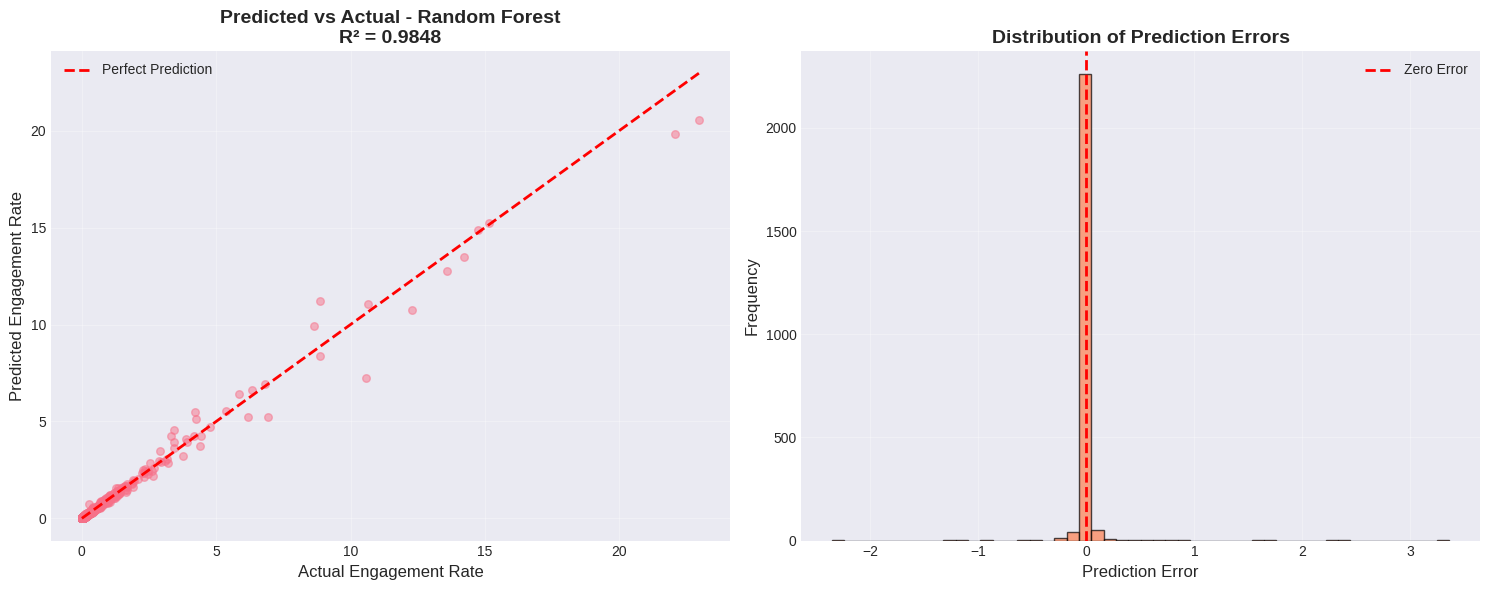

In [17]:
# PART 13: PREDICTED VS ACTUAL VISUALIZATION

print("MODEL PERFORMANCE VISUALIZATION")

# Predicted vs Actual plot with correct linear relationship
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Predicted vs Actual (CORRECTED)
axes[0].scatter(y_test, y_pred_optimized, alpha=0.5, s=30)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
            'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Engagement Rate', fontsize=12)
axes[0].set_ylabel('Predicted Engagement Rate', fontsize=12)
axes[0].set_title(f'Predicted vs Actual - {best_model_name}\nR² = {optimized_r2:.4f}',
                 fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Error distribution
errors = y_test - y_pred_optimized
axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Prediction Error', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Prediction Errors', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('predicted_vs_actual_corrected.png', dpi=300, bbox_inches='tight')
print("Predicted vs Actual visualization saved (CORRECTED LINEAR PLOT)")
plt.show()

In [18]:
# PART 14: MODEL PERFORMANCE SUMMARY

print("\nMODEL PERFORMANCE SUMMARY:")
print(f"  Best Model: {best_model_name}")
print(f"  Test R²: {optimized_r2:.4f}")
print(f"  Test RMSE: {optimized_rmse:.6f}")
print(f"  Cross-Validation R²: {grid_search.best_score_:.4f}")



MODEL PERFORMANCE SUMMARY:
  Best Model: Random Forest
  Test R²: 0.9848
  Test RMSE: 0.138471
  Cross-Validation R²: 0.9349
